# 1 - Model Generation

This Jupyter notebook contains the entire model generation procedure used to construct logistic regression predictors for outcome of Ebola patients. The training data includes 470 patients treated at the ETUs managed by IMC in Liberia and Sierra Leone between 2014 and 2015. Ssee [Skrable (2017)](http://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0005700) for details on this dataset.

However, only the patients from Sierra Leone are included in the training because the missing patters do not seem at random in the Liberian data. This reduces the training set to 292. Multiple imputation and boostrap validation are used to account for missing data and to produce internal evaluation without spliting the data into separate trainig and validation sets, which decreases model's power.

# Initialization

In [2]:
import pandas as pd
from os import listdir, makedirs
from os.path import isfile, join, exists

# This disables the warnings from RPy2 when R loads libraries that in turn load other dependencies
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Use the RWinOut instead of rpy2.ipython to get output on windows 
# https://bitbucket.org/rpy2/rpy2/issues/125/set_writeconsole-not-working-on-windows
# https://github.com/vitorcurtis/RWinOut
#%load_ext RWinOut
%load_ext rpy2.ipython

In [3]:
%%R

# Load required R libraries

library(rms)
library(Hmisc)
library(glmnet)
library(mvnormtest)
library(BaylorEdPsych)
library(MissMech)

R[write to console]: Loading required package: Hmisc

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘Hmisc’


R[write to console]: The following objects are masked from ‘package:base’:

    format.pval, units


R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve


R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: foreach

R[write to console]: Loaded glmnet 2.0-16




In [4]:
%%R 

# Random seed for reproducibility. Is reset at the beginning of each 
# calculating that involves randomization, so cells can be run in 
# arbitrary order and still reproduce results.

random_seed <- 151 

In [5]:
# Data file and modeling parameters

src_data_file = '../data/data_normalized.csv' 

include_temp = True   # Include body temperature into all models
include_ctrt = True   # Include the referral time x Ct term into the parsimonious models
use_sat_impute = True # Use imputation from saturated model in all reduced models

num_imp = 100   # Number of multiple imputations
num_boot = 200  # Number of bootstrap samples

In [6]:
# Some utility functions in Python

# Replaces PatientAge and FeverTemperature by Restricted Cubic Splines of order 3
def addRCSTerms(model_formula):
    formula = model_formula.replace('PatientAge', 'rcs(PatientAge,3)')
    formula = formula.replace('FeverTemperature', 'rcs(FeverTemperature,3)')    
    return formula

def makeImputeFormula(out_var, pred_vars):
    imp_vars = pred_vars.copy()
    if 'FeverTemperature' in imp_vars and not 'Fever' in imp_vars: 
        imp_vars += ['Fever']
    if 'reftime*cycletime' in imp_vars:
        imp_vars.remove('reftime*cycletime')        
    formula = '~' + '+'.join([out_var] + imp_vars)
    return formula

def makeLogRegFormula(out_var, pred_vars):
    formula = addRCSTerms(out_var + '~' + '+'.join(pred_vars))
    return formula

def createModelFolder(path):    
    if not exists(path):
        makedirs(path)
    return path

In [7]:
%%R 

# Some utility functions in R

# Trims leading and trailing whitespaces
# https://stackoverflow.com/a/21882152
trim <- function(x) {
    return(gsub("(^[[:space:]]+|[[:space:]]+$)", "", x))
}

# Extract single frame from MI data
# https://stackoverflow.com/a/42820029
getImpute <- function(impute, data = src_data, im = 1) {
  cbind.data.frame(impute.transcan(x = impute, 
                                   imputation = im, 
                                   data = data, 
                                   list.out = TRUE, 
                                   pr = FALSE))
}

# Auxiliary (X^3)+
cubic <- function(u) {
   t <- max(0, u)
   return(t * t * t)
}

# Calculates the RCS term given the valuex, the term index, and the knots
rcsFun <- function(x, term, knots) {
    k <- length(knots) 
    j <- term
    t <- knots
    c <- (t[k] - t[1]) * (t[k] - t[1])
    value <- +cubic(x - t[j])
             -cubic(x - t[k - 1]) * (t[k] - t[j])/(t[k] - t[k-1])
             +cubic(x - t[k]) * (t[k - 1] - t[j])/(t[k] - t[k-1]) 
    return(value / c)  
}

# Arrange dataframe vars by position
# 'vars' must be a named vector, e.g. c("var.name"=1)
# https://stackoverflow.com/a/37009127
arrangeVars <- function(data, vars) {
    # Stop if not a data.frame (but should work for matrices as well)
    stopifnot(is.data.frame(data))

    # Sort out inputs
    data.nms <- names(data)
    var.nr <- length(data.nms)
    var.nms <- names(vars)
    var.pos <- vars
    
    # Sanity checks
    stopifnot(!any(duplicated(var.nms)), 
              !any(duplicated(var.pos)))
    stopifnot(is.character(var.nms), 
              is.numeric(var.pos))
    stopifnot(all(var.nms %in% data.nms))
    stopifnot(all(var.pos > 0), 
              all(var.pos <= var.nr))

    # Prepare output
    out.vec <- character(var.nr)
    out.vec[var.pos] <- var.nms
    out.vec[-var.pos] <- data.nms[ !(data.nms %in% var.nms) ]
    stopifnot( length(out.vec)==var.nr )

    # Re-arrange vars by position
    data <- data[, out.vec]
    return(data)
}

saveToTXT <- function(obj, dir, fn) {
    sink(paste0(dir, "/", fn), append=FALSE, split=FALSE)
    print(obj)
    sink()    
}

saveToPDF <- function(obj, dir, fn) {
    pdf(paste0(dir, "/", fn), useDingbats=FALSE)
    plot(obj)
    dev.off()
}

saveModelToCSV <- function(f, vars, dir) {
    terms = names(f$coefficients)
    coeff = unname(f$coefficients)

    # Extract RCS knots from model specs. 
    # This code is now specific to get the knots for age and fever temperature, 
    # but it could be generalized easily by providing a list with all the 
    # variables modeled as RCS.
    
    spec = specs(f)
    # print(str(spec)) # This is useful to understand the structure of the object
    
    ageIdx <- which(vars == "PatientAge")
    tempIdx <- which(vars == "FeverTemperature")
    prodIdx <- which(vars == "reftime*cycletime")
    
    ageKnots <- spec$how.modeled[ageIdx, 2]
    tempKnots <- spec$how.modeled[tempIdx, 2]
    ageKnots <- trim(ageKnots)
    tempKnots <- trim(tempKnots)

    types <- rep.int("linear", length(terms))
    knots = rep.int("none", length(terms))

    age0 <- which(terms == "PatientAge")
    age1 <- which(terms == "PatientAge'")

    temp0 <- which(terms == "FeverTemperature")
    temp1 <- which(terms == "FeverTemperature'")

    prod0 <- which(terms == "cycletime * reftime")
    
    types[age0] <- "RCS0"
    types[age1] <- "RCS1"
    knots[age1] <- ageKnots

    types[temp0] <- "RCS0"
    types[temp1] <- "RCS1"
    knots[temp1] <- tempKnots
    
    types[prod0] = "product"

    model <- data.frame("Term" = terms, "Coefficient" = coeff, "Type" = types, "Knots" = knots)
    write.table(model, file = paste0(dir, "/model.csv"), sep = ",", row.names=FALSE, qmethod = "double")    
}

saveDescription <- function(f, vars, dir) {
    print(f)
    saveToTXT(f, dir, "model.txt")
    saveToTXT(specs(f), dir, "specs.txt")
    
    saveModelToCSV(f, vars, dir)    
}

saveEvaluation <- function(an, val, cal, dir) {
    print(val)
    plot(cal)

    saveToTXT(an, dir, "anova.txt")
    saveToPDF(an, dir, "anova.pdf")

    saveToTXT(val, dir, "validation.txt")
    saveToPDF(cal, dir, "calibration.pdf")    
}

generateModel <- function(rseed, nimp, nboot, fimp, flgr, sdat, vars, dir) {
    set.seed(rseed)
    
    # Impute data and fit pooled model
    imp_res <- aregImpute(as.formula(fimp), data=sdat, n.impute=nimp)
    pool_mdl <- fit.mult.impute(as.formula(flgr), lrm, imp_res, data=sdat)

    # Calculate ANOVA and validation/calibration
    mdl_anv <- anova(pool_mdl)
    mdl_upd <- update(pool_mdl, x=TRUE, y=TRUE)
    mdl_val <- validate(mdl_upd, B=nboot)
    mdl_cal <- calibrate(mdl_upd, B=nboot)

    # Calculate distribution summaries for potential predictor variables
    saveDescription(f=pool_mdl, vars=vars, dir=dir)
    saveEvaluation(an=mdl_anv, val=mdl_val, cal=mdl_cal, dir=dir)

#     f <- mdl_upd    
#     df <- getImpute(impute=imp_res, im=1)
#     dd <- datadist(df)
    # Trick to reset the options, as described in https://www.burns-stat.com/the-options-mechanism-in-r/
#     oldopt <- options(datadist='dd') 
#     on.exit(options(oldopt))
    
    # Partial effects plot (from code in pp 279 in Harrel's Regression Modeling Strategies, figure 11.2)
    # Not working inside a function though, gives the error:
    # variable xxx does not have limits defined by datadist
#     pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
#     print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
#                  rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
#     dev.off()
 
    # Odds ratios plot for all variables in the model, showing interquartile-range ORs for continuous
    # predictors and simple ORs for categorical variables (figure 11.3 in same book)
    # Not working either inside a function
#     pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
#     plot(summary(f), log=TRUE)  
#     dev.off()

#     plot(summary(f), log=TRUE)    
}

rcsAge <- function(x, term) {
    return(rcsFun(x, term, c(5, 30, 58)))
}

rcsTemp <- function(x, term) {
    return(rcsFun(x, term, c(36.3, 37.3, 39.4)))
}

prodCTRT <- function(x, y) {
    return(x*y)
}

selectVariables <- function(rseed, nimp, fimp, sdat, age, temp, ctrt) {
    set.seed(rseed)

    # Generate imputed datasets
    formula <- as.formula(fimp)
    imp_data <- aregImpute(formula, data=sdat, n.impute=nimp)

    # Setup the LASSO

    # alpha=0 is Ridge Regression (L1 norm penalty only)
    # alpha=0.5 is elastic net (mixture of L1 and L2 at a 50%)
    # alpha=1 is lasso (L2 norm penalty only)
    aelast = 0.5 # actually, we are using the elastic net

    # Set binomial as the prediction family so we run logistic regression
    predfam = "binomial"

    # Iterate over imputations
    coeffs <- list()
    for (i in 1:nimp) {
        df <- getImpute(impute = imp_data, im = i)

        # Transform the patient age and fever temperature into their RCS terms, that get
        # added to the data frame
        drops <- c()
        if (age) {
            df$PatientAge1 <- mapply(rcsAge, df$PatientAge, 1)
            df$PatientAge2 <- mapply(rcsAge, df$PatientAge, 2) 
            drops <- c(drops, "PatientAge")
        }

        if (temp) {
            df$FeverTemperature1 <- mapply(rcsTemp, df$FeverTemperature, 1)
            df$FeverTemperature2 <- mapply(rcsTemp, df$FeverTemperature, 2)
            drops <- c(drops, "FeverTemperature")
        }

        if (ctrt) {
            df$ct_rt <- mapply(prodCTRT, df$cycletime, df$reftime)
        }    

        # And remove the original variables 
        df <- df[ , !(names(df) %in% drops)]

        # Get outcome and predictor variables
        y <- as.matrix(df[,1])    
        x <- as.matrix(df[,2:ncol(df)])

        # Finds optimal lambda by cross-validation
        cv <- cv.glmnet(x, y, family=predfam, alpha=aelast, nfolds=10)
        lbest <- cv$lambda.min

        # Fit model
        fit <- glmnet(x, y, family=predfam, alpha=aelast, lambda=lbest)

        # Store coefficients  
        coeffs[[i]] <- coef(fit, s = "lambda.min")
    }

    ncoeff <- length(rownames(coeffs[[1]]))
    counts <- list()
    for (v in 1:ncoeff) {
        name <- rownames(coeffs[[1]])[v]
        c <- 0.0  
        for (i in 1:nimp) {
            if (0 < coeffs[[i]][v]) {
                c <- c + 1    
            }
        }
        counts[[name]] <- c/nimp  
    }

    # Sorting the counts https://stackoverflow.com/a/30651395
    counts <- counts[order(unlist(counts), decreasing=TRUE)]

    # And print out...
    res_names <- c()
    res_counts <- c()    
    for (k in names(counts)) {    
        n <- counts[[k]]
        cat(k, counts[[k]], '\n')
        res_names <- c(res_names, k)
        res_counts <- c(res_counts, n)
    }

    newList <- list("names" = res_names, "counts" = res_counts)
}

In [8]:
%%R -i src_data_file

# Load the source data

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

# Records only from Sierra Leone
sl_data <- src_data[src_data$ETUKey == 2 | src_data$ETUKey == 4 | src_data$ETUKey == 5, ]

# Records only from Liberia
lb_data <- src_data[src_data$ETUKey == 1 | src_data$ETUKey == 3, ]

# Records that are not missing wellness scale
ws_data <- sl_data[!is.na(sl_data$WellnessScale), ]

summary_table = data.frame(do.call(cbind, lapply(src_data, summary)))
print(summary_table)

        PatientKey   ETUKey PatientAge PatientSex Disposition     Fever
Min.      23209.00 1.000000    0.01000  0.0000000   0.0000000 0.0000000
1st Qu.   23447.50 1.000000   16.00000  0.0000000   0.0000000 1.0000000
Median    24329.00 2.000000   30.00000  0.0000000   1.0000000 1.0000000
Mean      24265.26 2.478723   30.48386  0.4051173   0.5763441 0.7526652
3rd Qu.   24789.00 4.000000   43.00000  1.0000000   1.0000000 1.0000000
Max.      26109.00 5.000000   80.00000  1.0000000   1.0000000 1.0000000
NA's      23209.00 1.000000    4.00000  1.0000000   5.0000000 1.0000000
        FeverNoDays DaysSinceSymptomOnset    reftime FeverTemperature  Headache
Min.       0.000000              0.000000   0.000000         35.40000 0.0000000
1st Qu.    2.000000              2.000000   2.000000         36.80000 0.0000000
Median     3.000000              4.000000   4.000000         37.30000 1.0000000
Mean       3.516949              4.286195   4.232044         37.58146 0.5820896
3rd Qu.    4.000000     

In [9]:
src_data = pd.read_csv(src_data_file, na_values='\\N')
sl_data = src_data[(src_data['ETUKey'] == 2) | (src_data['ETUKey'] == 4) | (src_data['ETUKey'] == 5)]
lb_data = src_data[(src_data['ETUKey'] == 1) | (src_data['ETUKey'] == 3)]

mdead = len(src_data[src_data['Disposition'] == 1])
msurv = len(src_data[src_data['Disposition'] == 0])

print('Recommended maximum DOF:', str(round(min(mdead, msurv) / 15)))

all_vars = list(src_data.columns.values)

print()
print('All variables in the data:')
print(all_vars)
print("")

# Variable we want to predict
out_var = 'Disposition'

all_vars = all_vars[2:all_vars.index('Bleeding') + 1]
all_vars += ['BoneMuscleJointPain', 'malaria1', 'cycletime', 'WellnessScale', 'ReferralTime']

pred_vars = all_vars.copy()

# Remove output variable
pred_vars.remove(out_var)

keep = []
if include_temp:
    keep += ['FeverTemperature']

# Remove variables with more than 50% of missing values either in Sierra Leone or Liberia cohorts.
sl_mfrac = sl_data.isnull().sum() / len(sl_data)
lb_mfrac = lb_data.isnull().sum() / len(lb_data)
tmp = pred_vars.copy()
for v in tmp:
    if v in keep: continue
    if 0.5 < sl_mfrac[v]:
        print("Removing", v, "(missing " + str(int(sl_mfrac[v] * 100)) + "% in Sierra Leone)")
        pred_vars.remove(v)
        continue
    if 0.5 < lb_mfrac[v]:
        print("Removing", v, "(missing " + str(int(lb_mfrac[v] * 100)) + "% in Liberia)")
        pred_vars.remove(v)
        continue
        
include_age = 'PatientAge' in pred_vars

print()
print("All predictive variables:")
print(pred_vars)
print("")
print("Number of variables:", len(pred_vars))

Recommended maximum DOF: 13

All variables in the data:
['PatientKey', 'ETUKey', 'PatientAge', 'PatientSex', 'Disposition', 'Fever', 'FeverNoDays', 'DaysSinceSymptomOnset', 'reftime', 'FeverTemperature', 'Headache', 'Nausea', 'Vomit', 'BloodyVomit', 'Diarrhoea', 'Anorexia', 'Cough', 'ChestPain', 'HaemorrhagicEyes', 'OtherHaemorrhage', 'Breathlessness', 'LossAppetite', 'AnorexiaLossAppetite', 'AstheniaWeakness', 'AbdominalPain', 'Jaundice', 'Throat', 'SwallowingProblems', 'Rash', 'Hiccups', 'Photophobia', 'Confusion', 'Coma', 'Bleeding', 'Gums', 'Stool', 'DigestVomit', 'Vagina', 'Skin', 'Urine', 'EbolaContact', 'Fluids', 'Travel', 'IllInFamily', 'VisitedSomeoneIll', 'SomebodyDiedRecently', 'BeenToFuneral', 'SuspicionEbola', 'PatientPregnant', 'PatientFarAlong', 'PatientHealthcareWorker', 'cycletime1', 'malaria1', 'cycletime2', 'BoneMuscleJointPain', 'BMI', 'cycletime', 'WellnessScale', 'NoSymptoms', 'ReferralTime', 'VomitNausea', 'Headache_R', 'StomachPain_R', 'Weakness_R', 'Anorexia_R'

# Normality and MCAR tests

We now perform some calculations on all the a-priori model variables, to determine a number of important properties: normal distribution of the data, Missing Completely at Random (MCAR) condition.

We use the package mvnormtest to test for multivariate normality, using the Shapiro-Wilk test:

In [10]:
test_vars = pred_vars + ['Disposition']

In [11]:
%%R -i test_vars

set.seed(random_seed)

# The test can only be performend on complete data
test_data <- src_data[unlist(test_vars)]
df <- test_data[complete.cases(test_data), ]
mat <- t(as.matrix(sapply(df, as.numeric)))
print(mshapiro.test(mat))


	Shapiro-Wilk normality test

data:  Z
W = 0.76237, p-value = 2.454e-10



Given that the data is normal, we can apply the Little's test for MCAR:

In [12]:
%%R -i test_vars
test_data <- src_data[unlist(test_vars)]
res <- LittleMCAR(test_data)
print("")
print(res$p.value)

R[write to console]: Loading required package: mvnmle



this could take a while[1] ""
[1] 0.0002103668


Since the test is significant, the MCAR hypthesis is rejected on the entire dataset. Let's apply the test separately on the data from Sierra Leone and Liberia, to see if the non-randomness in the missing data can be attributed to the differences in data availability due to the location of the ETU's:

In [13]:
%%R -i test_vars

# Sierra Leone

test_data <- sl_data[unlist(test_vars)]
res <- LittleMCAR(test_data)
print("")
print(res$p.value)

this could take a while[1] ""
[1] 0.03006459


In [14]:
%%R -i test_vars

# Liberia

v <- unlist(test_vars)

v <- v[!v %in% c('FeverTemperature')]

test_data <- lb_data[v]
res <- LittleMCAR(test_data)
print("")
print(res$p.value)

this could take a while[1] ""
[1] 0.08907454


The MCAR hypthesis cannot be rejected for the Liberian data, while it is still rejected, although with a much higer P-value, for the Sierra Leonean data. One variable that could potentially be confounding non-randomness in the missing values is reftime, as pointed out by [Hartley (2017)](http://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0005265) given its effect on mortality due to delayed presentation (which also depends on the viral load of the patient). We can start by simply removing that variable:

In [15]:
%%R -i test_vars

# Sierra Leone

v <- unlist(test_vars)

v <- v[!v %in% c('reftime')]

test_data <- sl_data[v]
res <- LittleMCAR(test_data)
print("")
print(res$p.value)

this could take a while[1] ""
[1] 0.2238532


In [16]:
%%R -i test_vars

# Controling by CT in Sierra Leone

test_data <- sl_data[unlist(test_vars)]

test_data1 <- test_data[which(test_data$cycletime <= 0),]
test_data2 <- test_data[which(test_data$cycletime > 0),]

# test_data1 <- test_data[which(test_data$reftime <= 3),]
# test_data2 <- test_data[which(test_data$reftime > 3),]

res <- LittleMCAR(test_data1)
print("")
print(res$p.value)

res <- LittleMCAR(test_data2)
print("")
print(res$p.value)

this could take a while[1] ""
[1] 0.556765
this could take a while[1] ""
[1] 0.1402589


# Saturated model

We now fit a logistic regression model on all the variables.

In [17]:
# Setting the formulas for the imputation and logistic regression fitting of the fully 
# saturated model

sat_vars = pred_vars + ['reftime*cycletime']

sat_imp_formula = makeImputeFormula(out_var, sat_vars)
sat_lgr_formula = makeLogRegFormula(out_var, sat_vars)
print(sat_imp_formula)
print(sat_lgr_formula)

sat_folder = createModelFolder('all-saturated')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime
Disposition~rcs(PatientAge,3)+PatientSex+Fever+reftime+rcs(FeverTemperature,3)+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime+reftime*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

           Intercept           PatientAge          PatientAge' 
                2.32                 1.14                 1.14 
          PatientSex                Fever              reftime 
                1.06                 1.26                 1.30 
    FeverTemperature    FeverTemperature'             Headache 
                2.32                 1.92                 1.11 
               Vomit            Diarrhoea     HaemorrhagicEyes 
                1.10                 1.22                 1.11 
      Breathlessness AnorexiaLossAppetite     AstheniaWeakness 
                1.08                 1.12                 1.13 
       AbdominalPain             Jaundice   SwallowingProblems 
                1.10                 1.13                 1.20 
             Hiccups             Bleeding  BoneMuscleJointPain 
                1.16                 1.08                 1.11 
           cycletime  reftime * cycletime

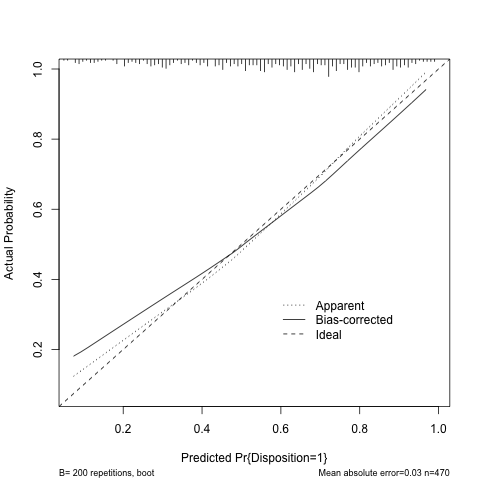

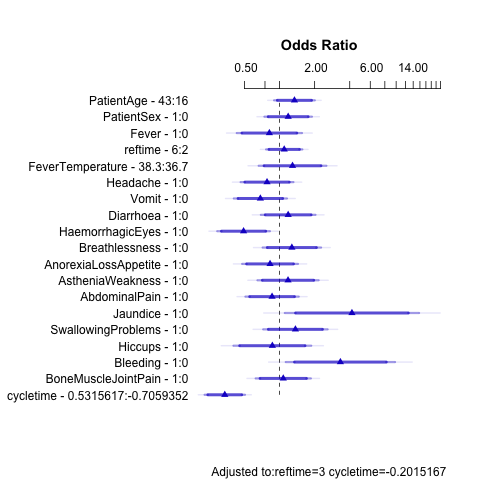

In [18]:
%%R -i num_imp,num_boot,sat_imp_formula,sat_lgr_formula,sat_folder,sat_vars

set.seed(random_seed)

# Impute data and fit pooled model
sat_impute <- aregImpute(as.formula(sat_imp_formula), data=src_data, n.impute=num_imp)
sat_model <- fit.mult.impute(as.formula(sat_lgr_formula), lrm, sat_impute, data=src_data)

# Calculate ANOVA and validation/calibration
sat_anova <- anova(sat_model)
sat_update <- update(sat_model, x=TRUE, y=TRUE)
sat_val <- validate(sat_update, B=num_boot)
sat_cal <- calibrate(sat_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
sat_datadist <- datadist(getImpute(impute = sat_impute, im = 1))


saveDescription(f=sat_model, vars=sat_vars, dir=sat_folder)
saveEvaluation(an=sat_anova, val=sat_val, cal=sat_cal, dir=sat_folder)

options(datadist='sat_datadist')
dir <- sat_folder
df <- getImpute(impute=sat_impute, im=1)
f <- sat_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

The saturated model has a AUC (C statistic) on the training data of 0.787, and an optimism in Dxy of 0.0794. Since C and Dxy are related by C = 0.5 + Dxy/2, the optimism corrected C is ~0.75, so the saturated model has a degree of overfitting to the data, although is not too bad. Some clinical symptoms have ORs lower than 1. This seems to indicate they increase the odds of survival, which does not make medical sense.


# Variable selection with penalized regression

Here we use [Elastic Net Regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization) for variable selection. We run the regularized logistic regression with the [Glmnet package](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) on each imputed dataset, and calculate how many times the coefficient for each variable over all the regressions is greater than zero. 

We are looking for variables that consistenly show non-negative coefficients since they represent clinical signs/symptoms at presentation that should be related with decreased changes of recovery. There are exceptions to this, for example cycletime has a negative coefficient since larger CT values indicate lower viral load and thus higher chances of recovery.

In [18]:
%%R -i num_imp,sat_imp_formula,include_age,include_temp,include_ctrt -o selection

selection <- selectVariables(random_seed, num_imp, sat_imp_formula, src_data, 
                             include_age, include_temp, include_ctrt)

Iteration 103 
(Intercept) 1 
Jaundice 1 
Bleeding 1 
PatientAge1 1 
PatientAge2 1 
Breathlessness 0.96 
FeverTemperature1 0.96 
SwallowingProblems 0.74 
PatientSex 0.41 
Diarrhoea 0.23 
FeverTemperature2 0.22 
reftime 0.09 
AstheniaWeakness 0.09 
AnorexiaLossAppetite 0.01 
BoneMuscleJointPain 0.01 
Fever 0 
Headache 0 
Vomit 0 
HaemorrhagicEyes 0 
AbdominalPain 0 
Hiccups 0 
cycletime 0 
ct_rt 0 


We set the threshold for keeping a variable at +50% in the above list, meaning that the corresponding regression coefficient had to be positive at least in half of the models to be selected. As mentioned CT has a negative coefficient, and patient age and fever temperature are pre-determined, so we will only look at sign/symptoms above that threshold:

In [19]:
names = list(selection[0])
fraction = list(selection[1])

# These are predetermined, or not a model variable (i.e.: the intercept)
excluded = ['(Intercept)', 'PatientAge1', 'PatientAge2', 'FeverTemperature1', 'FeverTemperature2']

print('Variables to keep:')
for i in range(0, len(names)):
    if not names[i] in excluded and fraction[i] > 0.5:
        print(names[i], fraction[i])

Variables to keep:
Jaundice 1.0
Bleeding 1.0
Breathlessness 0.96
SwallowingProblems 0.74


Based on this ranking, and following the contained in [Hartley (2017)](http://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0005265) with regards to the factors that prognosticate mortality in Ebola:

> Several studies have already identified single symptoms statistically predictive for EVD mortality, such as confusion (15–17), diarrhoea,(16, 18) asthenia (15, 18), hiccups (14), haemorrhagic signs (14, 16, 19), dizziness (18), extreme fatigue (15), and high viral load (14, 17, 18, 20).

> 14. Hunt L, Gupta-Wright A, Simms V, Tamba F, Knott V, Tamba K, et al. Clinical presentation, biochemical, and haematological parameters and their association with outcome in patients with Ebola virus disease: an observational cohort study. The Lancet Infectious diseases. 2015 Nov;15(11):1292–9. pmid:26271406
> 15. Qin E, Bi J, Zhao M, Wang Y, Guo T, Yan T, et al. Clinical Features of Patients With Ebola Virus Disease in Sierra Leone. Clinical infectious diseases: an official publication of the Infectious Diseases Society of America. 2015 Aug 15;61(4):491–5.
> 16. WHO Ebola Response Team. Ebola virus disease in West Africa—the first 9 months of the epidemic and forward projections. The New England journal of medicine. 2014 Oct 16;371(16):1481–95. Pubmed Central PMCID: 4235004. pmid:25244186
> 17. Zhang X, Rong Y, Sun L, Liu L, Su H, Zhang J, et al. Prognostic Analysis of Patients with Ebola Virus Disease. PLoS neglected tropical diseases. 2015 Sep;9(9):e0004113. Pubmed Central PMCID: 4580459. pmid:26398207
> 18. Schieffelin JS, Shaffer JG, Goba A, Gbakie M, Gire SK, Colubri A, et al. Clinical illness and outcomes in patients with Ebola in Sierra Leone. The New England journal of medicine. 2014 Nov 27;371(22):2092–100. Pubmed Central PMCID: 4318555. pmid:25353969
> 19. Barry M, Traore FA, Sako FB, Kpamy DO, Bah EI, Poncin M, et al. Ebola outbreak in Conakry, Guinea: epidemiological, clinical, and outcome features. Medecine et maladies infectieuses. 2014 Dec;44(11–12):491–4. pmid:25391486
> 20. de La Vega MA, Caleo G, Audet J, Qiu X, Kozak RA, Brooks JI, et al. Ebola viral load at diagnosis associates with patient outcome and outbreak evolution. The Journal of clinical investigation. 2015 Dec;125(12):4421–8. Pubmed Central PMCID: 4665775. pmid:26551677

## Clinical-only variable selection

In [20]:
clin_vars = pred_vars.copy()
clin_vars.remove('cycletime')

sat_clin_imp_formula = makeImputeFormula(out_var, clin_vars)
print(sat_clin_imp_formula)

include_ctrt = False

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain


In [21]:
%%R -i num_imp,sat_clin_imp_formula,include_age,include_temp,include_ctrt -o selection_clinical_only

selection_clinical_only <- selectVariables(random_seed, num_imp, sat_clin_imp_formula, src_data, 
                                           include_age, include_temp, include_ctrt)

Iteration 103 
Breathlessness 1 
Jaundice 1 
Bleeding 1 
PatientAge1 1 
AstheniaWeakness 0.99 
SwallowingProblems 0.99 
PatientAge2 0.99 
FeverTemperature1 0.91 
(Intercept) 0.75 
Diarrhoea 0.66 
FeverTemperature2 0.11 
PatientSex 0.07 
reftime 0.01 
Fever 0 
Headache 0 
Vomit 0 
HaemorrhagicEyes 0 
AnorexiaLossAppetite 0 
AbdominalPain 0 
Hiccups 0 
BoneMuscleJointPain 0 


In [22]:
names_clin = list(selection_clinical_only[0])
fraction_clin = list(selection_clinical_only[1])

print('Variables to keep:')
for i in range(0, len(names_clin)):
    if not names_clin[i] in excluded and fraction_clin[i] > 0.5:
        print(names_clin[i], fraction_clin[i])

Variables to keep:
Breathlessness 1.0
Jaundice 1.0
Bleeding 1.0
AstheniaWeakness 0.99
SwallowingProblems 0.99
Diarrhoea 0.66


# Parsimonious model

In [23]:
pars_vars = ['PatientAge', 'cycletime',
             'FeverTemperature',
             'Jaundice', 'Bleeding', 'Breathlessness', 'SwallowingProblems',
             'reftime', 'reftime*cycletime']

if use_sat_impute: 
    pars_imp_formula = sat_imp_formula 
else: 
    pars_imp_formula = makeImputeFormula(out_var, pars_vars)
    
pars_lgr_formula = makeLogRegFormula(out_var, pars_vars)
print(pars_imp_formula)
print(pars_lgr_formula)

pars_folder = createModelFolder('all-parsimonious')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime
Disposition~rcs(PatientAge,3)+cycletime+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+SwallowingProblems+reftime+reftime*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

          Intercept          PatientAge         PatientAge'           cycletime 
               2.04                1.14                1.14                1.41 
   FeverTemperature   FeverTemperature'            Jaundice            Bleeding 
               2.03                1.75                1.10                1.07 
     Breathlessness  SwallowingProblems             reftime cycletime * reftime 
               1.07                1.11                1.24                1.33 

Rate of Missing Information:

          Intercept          PatientAge         PatientAge'           cycletime 
               0.51                0.12                0.12                0.29 
   FeverTemperature   FeverTemperature'            Jaundice            Bleeding 
               0.51                0.43                0.09                0.07 
     Breathlessness  SwallowingProblems             reftime cycletime * reftime 
               

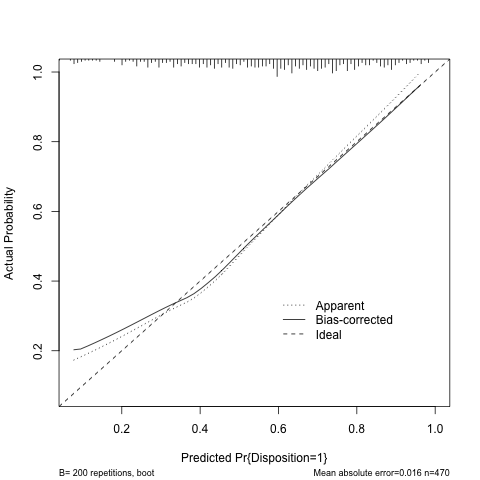

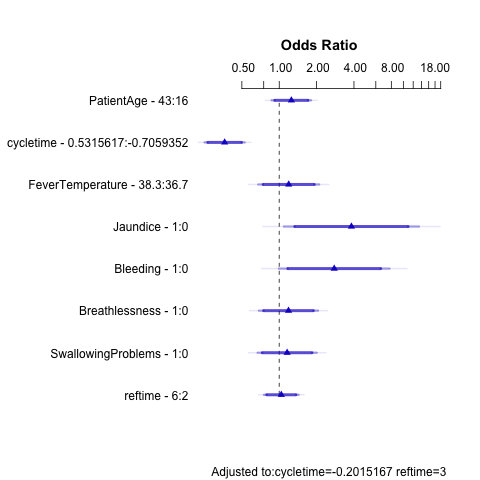

In [24]:
%%R -i num_imp,num_boot,pars_imp_formula,pars_lgr_formula,pars_vars,pars_folder

# generateModel(random_seed, num_imp, num_boot, pars_imp_formula, pars_lgr_formula, 
#               src_data, pars_vars, pars_folder)



set.seed(random_seed)

# Impute data and fit pooled model
pars_impute <- aregImpute(as.formula(pars_imp_formula), data=src_data, n.impute=num_imp)
pars_model <- fit.mult.impute(as.formula(pars_lgr_formula), lrm, pars_impute, data=src_data)

# Calculate ANOVA and validation/calibration
pars_anova <- anova(pars_model)
pars_update <- update(pars_model, x=TRUE, y=TRUE)
pars_val <- validate(pars_update, B=num_boot)
pars_cal <- calibrate(pars_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
pars_datadist <- datadist(getImpute(impute = pars_impute, im = 1))


saveDescription(f=pars_model, vars=pars_vars, dir=pars_folder)
saveEvaluation(an=pars_anova, val=pars_val, cal=pars_cal, dir=pars_folder)

options(datadist='pars_datadist')
dir <- pars_folder
df <- getImpute(impute=pars_impute, im=1)
f <- pars_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

# Parsimonious no fever temperature

In [27]:
pars_notemp_vars = ['PatientAge', 'cycletime',
                    'Jaundice', 'Bleeding', 'Breathlessness', 'SwallowingProblems',
                    'reftime', 'reftime*cycletime']

if use_sat_impute: 
    pars_notemp_imp_formula = sat_imp_formula 
else: 
    pars_notemp_imp_formula = makeImputeFormula(out_var, pars_notemp_vars)
    
pars_notemp_lgr_formula = makeLogRegFormula(out_var, pars_notemp_vars)
print(pars_notemp_imp_formula)
print(pars_notemp_lgr_formula)

pars_notemp_folder = createModelFolder('all-parsimonious-notemp')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime
Disposition~rcs(PatientAge,3)+cycletime+Jaundice+Bleeding+Breathlessness+SwallowingProblems+reftime+reftime*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

          Intercept          PatientAge         PatientAge'           cycletime 
               1.10                1.12                1.12                1.42 
           Jaundice            Bleeding      Breathlessness  SwallowingProblems 
               1.08                1.06                1.07                1.08 
            reftime cycletime * reftime 
               1.22                1.34 

Rate of Missing Information:

          Intercept          PatientAge         PatientAge'           cycletime 
               0.09                0.11                0.10                0.30 
           Jaundice            Bleeding      Breathlessness  SwallowingProblems 
               0.08                0.06                0.07                0.07 
            reftime cycletime * reftime 
               0.18                0.25 

d.f. for t-distribution for Tests of Single Coefficients:

          Intercept          Patie

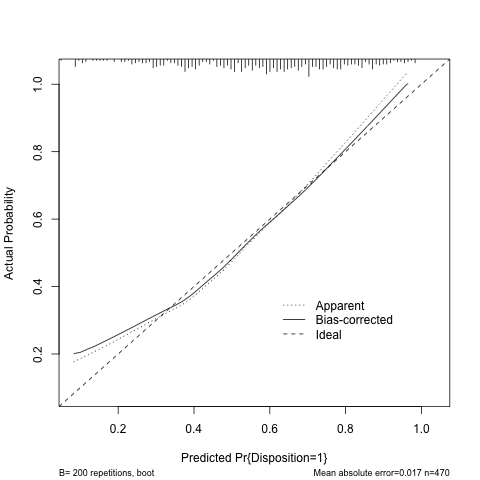

In [28]:
%%R -i num_imp,num_boot,pars_notemp_imp_formula,pars_notemp_lgr_formula,pars_notemp_vars,pars_notemp_folder

generateModel(random_seed, num_imp, num_boot, pars_notemp_imp_formula, pars_notemp_lgr_formula, 
              src_data, pars_notemp_vars, pars_notemp_folder)

# Clinical-only

In [29]:
clin_only_vars = ['PatientAge',
                  'FeverTemperature',
                  'Jaundice', 'Bleeding', 'Breathlessness', 'SwallowingProblems', 
                  'AstheniaWeakness', 'Diarrhoea']

if use_sat_impute: 
    clin_only_imp_formula = sat_imp_formula 
else: 
    clin_only_imp_formula = makeImputeFormula(out_var, clin_only_vars)

clin_only_lgr_formula = makeLogRegFormula(out_var, clin_only_vars)
print(clin_only_imp_formula)
print(clin_only_lgr_formula)

clin_only_folder = createModelFolder('all-clinical-only')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime
Disposition~rcs(PatientAge,3)+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+SwallowingProblems+AstheniaWeakness+Diarrhoea


Iteration 103 

Variance Inflation Factors Due to Imputation:

         Intercept         PatientAge        PatientAge'   FeverTemperature 
              1.98               1.05               1.04               1.97 
 FeverTemperature'           Jaundice           Bleeding     Breathlessness 
              1.68               1.02               1.03               1.03 
SwallowingProblems   AstheniaWeakness          Diarrhoea 
              1.05               1.04               1.10 

Rate of Missing Information:

         Intercept         PatientAge        PatientAge'   FeverTemperature 
              0.49               0.05               0.04               0.49 
 FeverTemperature'           Jaundice           Bleeding     Breathlessness 
              0.40               0.02               0.02               0.03 
SwallowingProblems   AstheniaWeakness          Diarrhoea 
              0.05               0.04               0.09 

d.f. for t-distribution for Tests of Single Coefficients:

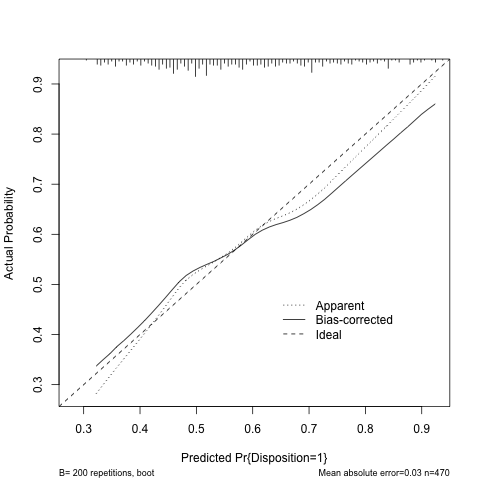

In [30]:
%%R -i num_imp,num_boot,clin_only_imp_formula,clin_only_lgr_formula,clin_only_vars,clin_only_folder

generateModel(random_seed, num_imp, num_boot, clin_only_imp_formula, clin_only_lgr_formula, 
              src_data, clin_only_vars, clin_only_folder)

# Minimal

In [31]:
min_vars = ['PatientAge', 'cycletime']

if use_sat_impute: 
    min_imp_formula = sat_imp_formula 
else: 
    min_imp_formula = makeImputeFormula(out_var, min_vars)
    
min_lgr_formula = makeLogRegFormula(out_var, min_vars)
print(min_imp_formula)
print(min_lgr_formula)

min_folder = createModelFolder('all-minimal')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime
Disposition~rcs(PatientAge,3)+cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

  Intercept  PatientAge PatientAge'   cycletime 
       1.12        1.11        1.12        1.47 

Rate of Missing Information:

  Intercept  PatientAge PatientAge'   cycletime 
       0.11        0.10        0.10        0.32 

d.f. for t-distribution for Tests of Single Coefficients:

  Intercept  PatientAge PatientAge'   cycletime 
    8494.99     9424.67     9193.41      957.41 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

  Intercept  PatientAge PatientAge'   cycletime 
       1.12        1.11        1.12        1.47 

Rate of Missing Information:

  Intercept  PatientAge PatientAge'   cycletime 
       0.11        0.10        0.10        0.32 

d.f. for t-distribution for Tests of Single Coefficients:

  Intercept  PatientAge PatientAge'   cycletime 
    8494.99     9424.67     9193.41      957.41 

The following fit co

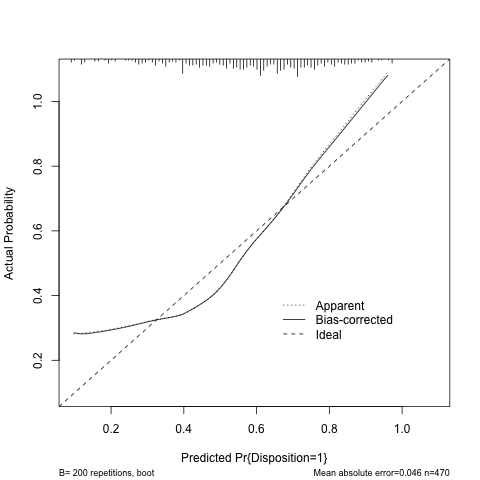

In [32]:
%%R -i num_imp,num_boot,min_imp_formula,min_lgr_formula,min_vars,min_folder

generateModel(random_seed, num_imp, num_boot, min_imp_formula, min_lgr_formula, 
              src_data, min_vars, min_folder)

# Wellness models

In [19]:
well_sat_imp_formula = makeImputeFormula(out_var, sat_vars + ['WellnessScale'])
print(well_sat_imp_formula)

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime+WellnessScale


## Wellness parsimonious

In [20]:
well_pars_vars = ['PatientAge', 'cycletime',
                  'FeverTemperature',
                  'WellnessScale',
                  'reftime', 'reftime*cycletime']

if use_sat_impute:
    well_pars_imp_formula = well_sat_imp_formula
else:
    well_pars_imp_formula = makeImputeFormula(out_var, well_pars_vars)
    
well_pars_lgr_formula = makeLogRegFormula(out_var, well_pars_vars)
print(well_pars_imp_formula)
print(well_pars_lgr_formula)

well_pars_folder = createModelFolder('sl-wellness-parsimonious')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime+WellnessScale
Disposition~rcs(PatientAge,3)+cycletime+rcs(FeverTemperature,3)+WellnessScale+reftime+reftime*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

          Intercept          PatientAge         PatientAge'           cycletime 
               1.38                1.19                1.17                1.60 
   FeverTemperature   FeverTemperature'       WellnessScale             reftime 
               1.39                1.39                1.40                1.69 
cycletime * reftime 
               1.86 

Rate of Missing Information:

          Intercept          PatientAge         PatientAge'           cycletime 
               0.28                0.16                0.14                0.37 
   FeverTemperature   FeverTemperature'       WellnessScale             reftime 
               0.28                0.28                0.29                0.41 
cycletime * reftime 
               0.46 

d.f. for t-distribution for Tests of Single Coefficients:

          Intercept          PatientAge         PatientAge'           cycletime 
            1281.73             3

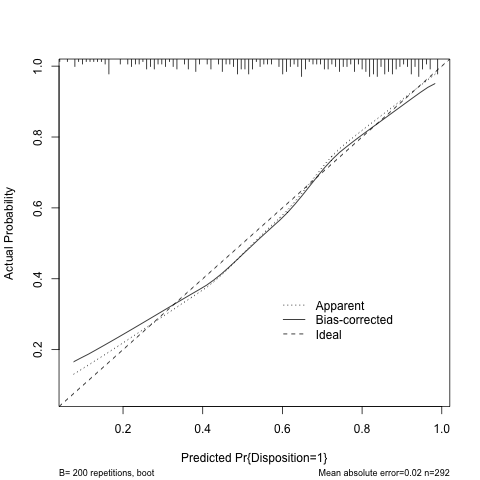

In [21]:
%%R -i num_imp,num_boot,well_pars_imp_formula,well_pars_lgr_formula,well_pars_vars,well_pars_folder

generateModel(random_seed, num_imp, num_boot, well_pars_imp_formula, well_pars_lgr_formula, 
              sl_data, well_pars_vars, well_pars_folder)

## Wellness no fever temperature

In [22]:
well_notemp_vars = ['PatientAge', 'cycletime',
                    'WellnessScale',
                    'reftime', 'reftime*cycletime']

if use_sat_impute:
    well_notemp_imp_formula = well_sat_imp_formula
else:
    well_notemp_imp_formula = makeImputeFormula(out_var, well_notemp_vars)
    
well_notemp_lgr_formula = makeLogRegFormula(out_var, well_notemp_vars)
print(well_notemp_imp_formula)
print(well_notemp_lgr_formula)

well_notemp_folder = createModelFolder('sl-wellness-parsimonious-notemp')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime+WellnessScale
Disposition~rcs(PatientAge,3)+cycletime+WellnessScale+reftime+reftime*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

          Intercept          PatientAge         PatientAge'           cycletime 
               1.34                1.19                1.16                1.60 
      WellnessScale             reftime cycletime * reftime 
               1.39                1.66                1.85 

Rate of Missing Information:

          Intercept          PatientAge         PatientAge'           cycletime 
               0.25                0.16                0.14                0.38 
      WellnessScale             reftime cycletime * reftime 
               0.28                0.40                0.46 

d.f. for t-distribution for Tests of Single Coefficients:

          Intercept          PatientAge         PatientAge'           cycletime 
            1569.28             3929.92             5082.88              701.15 
      WellnessScale             reftime cycletime * reftime 
            1257.74              621.99              46

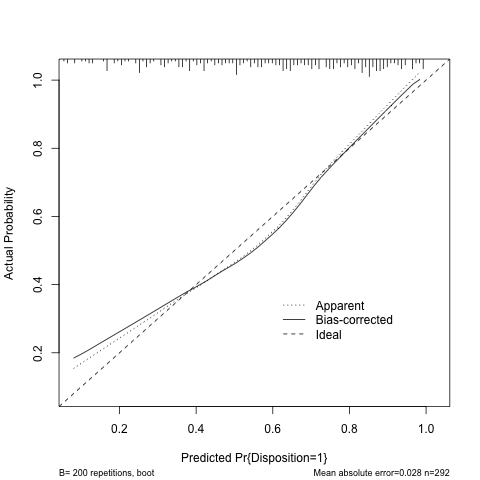

In [23]:
%%R -i num_imp,num_boot,well_notemp_imp_formula,well_notemp_lgr_formula,well_notemp_vars,well_notemp_folder

generateModel(random_seed, num_imp, num_boot, well_notemp_imp_formula, well_notemp_lgr_formula, 
              sl_data, well_notemp_vars, well_notemp_folder)

## Wellness clinical-only

In [24]:
well_clin_only_vars = ['PatientAge',
                       'FeverTemperature',
                       'WellnessScale']

if use_sat_impute:
    well_clin_only_imp_formula = well_sat_imp_formula
else:
    well_clin_only_imp_formula = makeImputeFormula(out_var, well_clin_only_vars)
    
well_clin_only_lgr_formula = makeLogRegFormula(out_var, well_clin_only_vars)
print(well_clin_only_imp_formula)
print(well_clin_only_lgr_formula)

well_clin_only_folder = createModelFolder('sl-wellness-clinical-only')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime+WellnessScale
Disposition~rcs(PatientAge,3)+rcs(FeverTemperature,3)+WellnessScale


Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             1.30              1.08              1.07              1.31 
FeverTemperature'     WellnessScale 
             1.35              1.24 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             0.23              0.07              0.07              0.24 
FeverTemperature'     WellnessScale 
             0.26              0.20 

d.f. for t-distribution for Tests of Single Coefficients:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
          1831.78          19542.76          22228.71           1784.79 
FeverTemperature'     WellnessScale 
          1464.69           2582.10 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge     

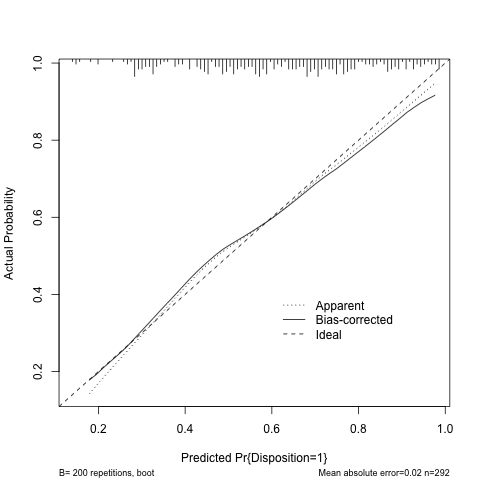

In [25]:
%%R -i num_imp,num_boot,well_clin_only_imp_formula,well_clin_only_lgr_formula,well_clin_only_vars,well_clin_only_folder

generateModel(random_seed, num_imp, num_boot, well_clin_only_imp_formula, well_clin_only_lgr_formula, 
              sl_data, well_clin_only_vars, well_clin_only_folder)

## Wellness minimal

In [26]:
well_min_vars = ['PatientAge', 'cycletime', 'WellnessScale']

if use_sat_impute:
    well_min_imp_formula = well_sat_imp_formula
else:
    well_min_imp_formula = makeImputeFormula(out_var, well_min_vars)
    
well_min_lgr_formula = makeLogRegFormula(out_var, well_min_vars)
print(well_min_imp_formula)
print(well_min_lgr_formula)

well_min_folder = createModelFolder('sl-wellness-minimal')

~Disposition+PatientAge+PatientSex+Fever+reftime+FeverTemperature+Headache+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+cycletime+WellnessScale
Disposition~rcs(PatientAge,3)+cycletime+WellnessScale


Iteration 103 

Variance Inflation Factors Due to Imputation:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         1.33          1.17          1.17          1.64          1.34 

Rate of Missing Information:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         0.25          0.14          0.14          0.39          0.25 

d.f. for t-distribution for Tests of Single Coefficients:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
      1586.05       4860.04       4934.94        649.67       1561.25 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         1.33          1.17          1.17          1.64          1.34 

Rate of Missing Information:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         0.25          0.14   

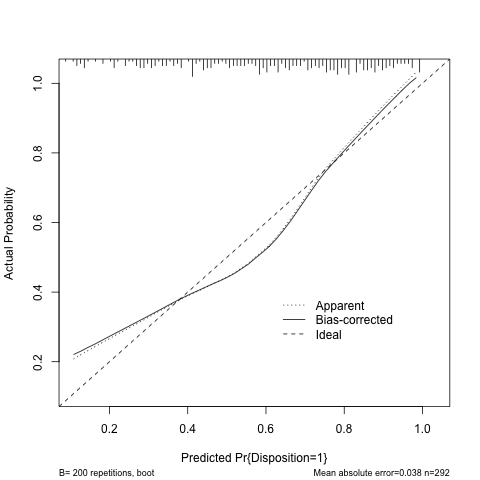

In [27]:
%%R -i num_imp,num_boot,well_min_imp_formula,well_min_lgr_formula,well_min_vars,well_min_folder

generateModel(random_seed, num_imp, num_boot, well_min_imp_formula, well_min_lgr_formula, 
              sl_data, well_min_vars, well_min_folder)

# Wellness models without missing wellness scale

In [28]:
well_pars_noimp_folder = createModelFolder('sl-wellness-parsimonious-noimp')

Iteration 103 

Variance Inflation Factors Due to Imputation:

          Intercept          PatientAge         PatientAge'           cycletime 
               1.57                1.13                1.12                1.43 
   FeverTemperature   FeverTemperature'       WellnessScale             reftime 
               1.56                1.51                1.09                1.43 
cycletime * reftime 
               1.58 

Rate of Missing Information:

          Intercept          PatientAge         PatientAge'           cycletime 
               0.36                0.11                0.11                0.30 
   FeverTemperature   FeverTemperature'       WellnessScale             reftime 
               0.36                0.34                0.08                0.30 
cycletime * reftime 
               0.37 

d.f. for t-distribution for Tests of Single Coefficients:

          Intercept          PatientAge         PatientAge'           cycletime 
             758.99             7

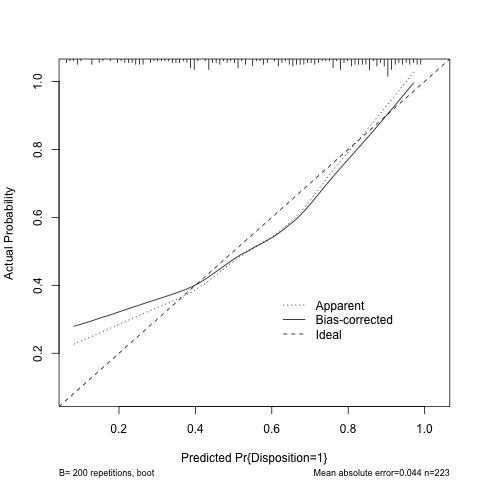

In [31]:
%%R -i num_imp,num_boot,well_pars_imp_formula,well_pars_lgr_formula,well_pars_vars,well_pars_noimp_folder

generateModel(random_seed, num_imp, num_boot, well_pars_imp_formula, well_pars_lgr_formula, 
              ws_data, well_pars_vars, well_pars_noimp_folder)

In [32]:
well_notemp_noimp_folder = createModelFolder('sl-wellness-parsimonious-notemp-noimp')

Iteration 103 

Variance Inflation Factors Due to Imputation:

          Intercept          PatientAge         PatientAge'           cycletime 
               1.11                1.10                1.11                1.39 
      WellnessScale             reftime cycletime * reftime 
               1.09                1.47                1.56 

Rate of Missing Information:

          Intercept          PatientAge         PatientAge'           cycletime 
               0.10                0.09                0.10                0.28 
      WellnessScale             reftime cycletime * reftime 
               0.08                0.32                0.36 

d.f. for t-distribution for Tests of Single Coefficients:

          Intercept          PatientAge         PatientAge'           cycletime 
           10405.20            11291.02             9644.33             1239.88 
      WellnessScale             reftime cycletime * reftime 
           14317.59              979.43              76

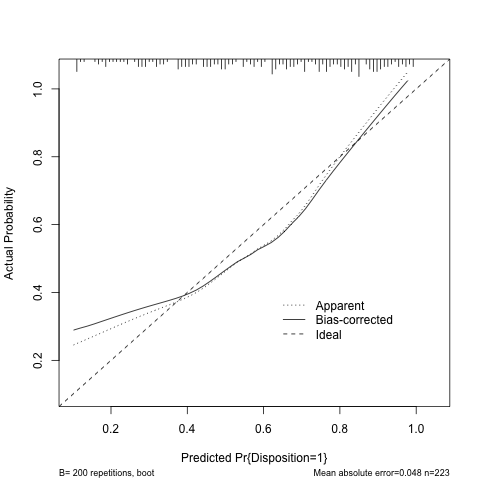

In [33]:
%%R -i num_imp,num_boot,well_notemp_imp_formula,well_notemp_lgr_formula,well_notemp_vars,well_notemp_noimp_folder

generateModel(random_seed, num_imp, num_boot, well_notemp_imp_formula, well_notemp_lgr_formula, 
              ws_data, well_notemp_vars, well_notemp_noimp_folder)

In [34]:
well_clin_only_noimp_folder = createModelFolder('sl-wellness-clinical-only-noimp')

Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             1.43              1.03              1.03              1.43 
FeverTemperature'     WellnessScale 
             1.42              1.01 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             0.30              0.03              0.03              0.30 
FeverTemperature'     WellnessScale 
             0.30              0.01 

d.f. for t-distribution for Tests of Single Coefficients:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
          1083.51         129916.68          96117.40           1083.51 
FeverTemperature'     WellnessScale 
          1129.17         554013.40 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge     

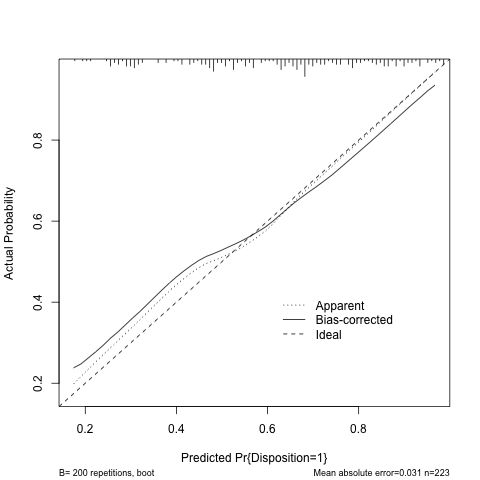

In [35]:
%%R -i num_imp,num_boot,well_clin_only_imp_formula,well_clin_only_lgr_formula,well_clin_only_vars,well_clin_only_noimp_folder

generateModel(random_seed, num_imp, num_boot, well_clin_only_imp_formula, well_clin_only_lgr_formula, 
              ws_data, well_clin_only_vars, well_clin_only_noimp_folder)

In [36]:
well_min_noimp_folder = createModelFolder('sl-wellness-minimal-noimp')

Iteration 103 

Variance Inflation Factors Due to Imputation:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         1.09          1.08          1.09          1.56          1.06 

Rate of Missing Information:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         0.08          0.08          0.08          0.36          0.06 

d.f. for t-distribution for Tests of Single Coefficients:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
     14558.39      17228.27      13763.90        772.20      30627.07 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         1.09          1.08          1.09          1.56          1.06 

Rate of Missing Information:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         0.08          0.08   

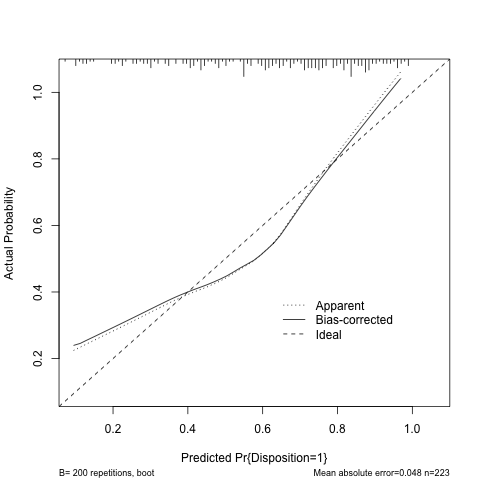

In [37]:
%%R -i num_imp,num_boot,well_min_imp_formula,well_min_lgr_formula,well_min_vars,well_min_noimp_folder

generateModel(random_seed, num_imp, num_boot, well_min_imp_formula, well_min_lgr_formula, 
              ws_data, well_min_vars, well_min_noimp_folder)